<a href="https://colab.research.google.com/github/benjaminsw/MResDissertation/blob/main/2_ReLU_three_classes_DarkCovidNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### install additional libraries

In [ ]:
!pip install split_folders


### check resources

In [ ]:
# export
import torch

def is_cuda_available():
    assert (
        torch.cuda.is_available()
    ), "PyTorch could not find cuda, you may have been suspended which breaks cuda support in the     environment."
    print("PyTorch found cuda.")
    return True

is_cuda_available()

PyTorch found cuda.


True

In [ ]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

1
Tesla T4


In [ ]:
#Assign cuda GPU located at location '0' to a variable
torch.device('cuda:0')

device(type='cuda', index=0)

In [ ]:
# check RAM
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('You are **NOT** using a high-RAM runtime')
else:
  print('You are **using** a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are **using** a high-RAM runtime!


### get data and rename directory

In [ ]:
!git clone https://github.com/benjaminsw/COVID-19.git

Cloning into 'COVID-19'...
remote: Enumerating objects: 1237, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 1237 (delta 27), reused 4 (delta 1), pack-reused 1156
Receiving objects: 100% (1237/1237), 400.89 MiB | 18.12 MiB/s, done.
Resolving deltas: 100% (29/29), done.


In [ ]:
# rename folder to remove white space
!mv 'COVID-19/X-Ray Image DataSet' 'COVID-19/X-Ray_Image_DataSet'

# list files in directory
!ls COVID-19/X-Ray_Image_DataSet

Covid-19  No_findings  Pneumonia


### import libary 

In [ ]:
import splitfolders
from fastai.vision import *
import fastai
import warnings
warnings.filterwarnings('ignore')

In [ ]:
splitfolders.ratio('/content/COVID-19/X-Ray_Image_DataSet', output='output', seed=2020, ratio=(.6, 0.2,0.2)) 

Copying files: 1125 files [00:00, 1891.96 files/s]


In [ ]:
path = Path('/content/output')

### Training a neural net in fast.ai

There are 2 concepts at a high level:

DataBunch: A general fastai concept for your data, and from there, there are subclasses for particular applications like ImageDataBunch

Learner: A general concept for things that can learn to fit a model. From that, there are various subclasses to make things easier in particular, there is a convnet learner (something that will create a convolutional neural network for you).

In [ ]:
np.random.seed(41)
data = ImageDataBunch.from_folder(path, train = 'train', valid = 'val', test = 'test',
        ds_tfms=get_transforms(), size=(256,256), bs=32, num_workers=4).normalize()
data

ImageDataBunch;

Train: LabelList (675 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
No_findings,No_findings,No_findings,No_findings,No_findings
Path: /content/output;

Valid: LabelList (225 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
No_findings,No_findings,No_findings,No_findings,No_findings
Path: /content/output;

Test: LabelList (225 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: EmptyLabelList
,,,,
Path: /content/output

In [ ]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds), len(data.test_ds)

(['Covid-19', 'No_findings', 'Pneumonia'], 3, 675, 225, 225)

In [ ]:
print("Number of examples in training:", len(data.train_ds))
print("Number of examples in validation:", len(data.valid_ds))
print("Number of examples in testset:", len(data.test_ds))

Number of examples in training: 675
Number of examples in validation: 225
Number of examples in testset: 225


In [ ]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([32, 3, 256, 256]), torch.Size([32]))

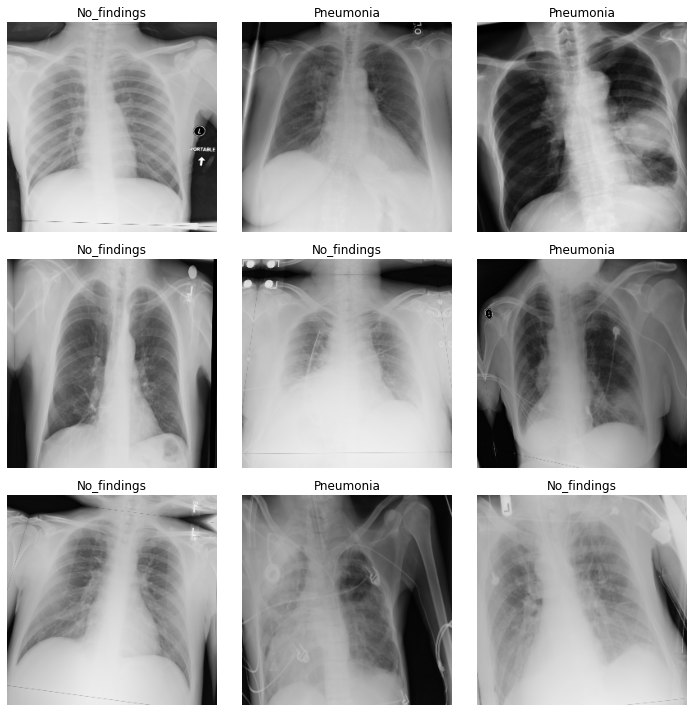

In [ ]:
data.show_batch(rows=3, figsize=(10,10))

### available models in fastAI

In [ ]:
# dir(fastai.vision.models)

### DarkCovidNet (modified Darknet model)

In [ ]:
def conv_block(ni, nf, size=3, stride=1):
    for_pad = lambda s: s if s > 2 else 3
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=size, stride=stride,
                  padding=(for_pad(size) - 1)//2, bias=False), 
        nn.BatchNorm2d(nf),
        nn.LeakyReLU(negative_slope=0.1, inplace=True)  
    )

In [ ]:
def triple_conv(ni, nf):
    return nn.Sequential(
        conv_block(ni, nf),
        conv_block(nf, ni, size=1),  
        conv_block(ni, nf)
    )

In [ ]:
def maxpooling():
    return nn.MaxPool2d(2, stride=2)

In [ ]:
model = nn.Sequential(
    conv_block(3, 8),
    maxpooling(),
    conv_block(8, 16),
    maxpooling(),
    triple_conv(16, 32),
    maxpooling(),
    triple_conv(32, 64),
    maxpooling(),
    triple_conv(64, 128),
    maxpooling(),
    triple_conv(128, 256),
    conv_block(256, 128, size=1),
    conv_block(128, 256),
    conv_layer(256, 3),
    Flatten(),
    nn.Linear(507, 3)
)

In [ ]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=[accuracy, error_rate])

In [ ]:
# learn.model.to('cuda')

In [ ]:
# print(learn.summary())

ref: 

1) https://iconof.com/1cycle-learning-rate-policy/

2) https://atmamani.github.io/projects/dl/fastai/fastai-1/


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


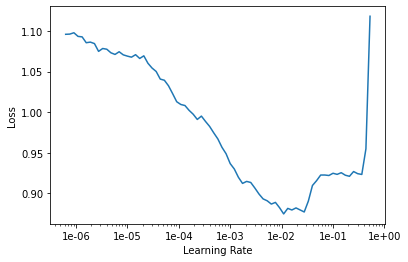

In [ ]:
# find learning rate
#learn.fit_one_cycle(5, max_lr=3e-3) 

# lr_find(learn:Learner, start_lr:Floats=1e-07, end_lr:Floats=10, num_it:int=100, stop_div:bool=True, wd:float=None)
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr_init=lr=1e-2
count=1
#with learn.no_bar(), learn.no_logging():
while lr > 1e-5:
  print(lr)

  #learn.fit_one_cycle(100, max_lr = lr) #1e-4 #100
  #learn.recorder.plot_losses()
  count=count+1
  lr=lr*0.1*0.5**count #lr_init*0.5**count

0.01
0.00025


### The 1cycle policy

ref: https://fastai1.fast.ai/callbacks.one_cycle.html#The-1cycle-policy

1. We progressively increase our learning rate from lr_max/div_factor to lr_max and at the same time we progressively decrease our momentum from mom_max to mom_min.
2. We do the exact opposite: we progressively decrease our learning rate from lr_max to lr_max/div_factor and at the same time we progressively increase our momentum from mom_min to mom_max.
3. We further decrease our learning rate from lr_max/div_factor to lr_max/(div_factor x 100) and we keep momentum steady at mom_max.

In [ ]:
learn.fit_one_cycle(100, max_lr = 7.8125e-05) #1e-4 #100

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.058222,1.128540,0.444444,0.555556,00:17
1,1.010345,1.020918,0.417778,0.582222,00:18
2,0.984139,0.937829,0.528889,0.471111,00:17
3,0.953504,0.903473,0.551111,0.448889,00:18
4,0.922742,0.874555,0.564444,0.435556,00:17
5,0.889933,0.846185,0.582222,0.417778,00:18
6,0.861695,0.809202,0.617778,0.382222,00:17
7,0.825322,0.778654,0.631111,0.368889,00:17
8,0.793878,0.747962,0.631111,0.368889,00:17
9,0.749221,0.735945,0.675556,0.324444,00:17


The learning rate and the momentum were changed during the epochs as follows

ref: https://fastai1.fast.ai/callbacks.html

In [ ]:
# learn.recorder.plot_lr(show_moms=True)

ref: https://towardsdatascience.com/using-fastai-for-image-classification-54d2b39511ce

In [ ]:
# interpreter = ClassificationInterpretation.from_learner(learn)
# interpreter.most_confused(min_val=2)

Here is the schedule of the lrs (left) and momentum (right) that the new 1cycle policy uses.

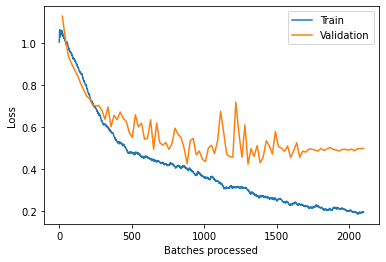

In [ ]:
learn.recorder.plot_losses()

### search learning rate 

0.01


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.826489,1.105734,0.444444,0.555556,00:18
1,0.732774,0.928591,0.555556,0.444444,00:17
2,0.656971,1.121387,0.520000,0.480000,00:18
3,0.606665,0.617757,0.755556,0.244444,00:17
4,0.598991,1.741765,0.586667,0.413333,00:17
5,0.571888,0.778340,0.693333,0.306667,00:18
6,0.553806,0.838268,0.715556,0.284444,00:17
7,0.556897,0.938048,0.706667,0.293333,00:17
8,0.567910,4.073905,0.351111,0.648889,00:17
9,0.574319,0.611544,0.706667,0.293333,00:17


0.0025


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.897817,1.083568,0.471111,0.528889,00:17
1,0.816880,0.837431,0.635556,0.364444,00:17
2,0.738191,0.637725,0.697778,0.302222,00:18
3,0.679843,0.606429,0.728889,0.271111,00:18
4,0.637809,0.829665,0.671111,0.328889,00:17
5,0.620403,0.694619,0.711111,0.288889,00:17
6,0.592757,0.616318,0.742222,0.257778,00:18
7,0.556896,0.646066,0.746667,0.253333,00:17
8,0.558858,1.117878,0.626667,0.373333,00:17
9,0.538767,0.559380,0.782222,0.217778,00:17


0.00125


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.991867,1.030566,0.444444,0.555556,00:17
1,0.909914,0.935637,0.586667,0.413333,00:17
2,0.829018,0.775250,0.640000,0.360000,00:17
3,0.765917,0.673038,0.737778,0.262222,00:17
4,0.728817,0.637548,0.697778,0.302222,00:17
5,0.679099,0.628725,0.742222,0.257778,00:17
6,0.643835,0.576361,0.737778,0.262222,00:17
7,0.620637,0.684966,0.697778,0.302222,00:18
8,0.620560,0.675899,0.728889,0.271111,00:17
9,0.592448,0.600969,0.737778,0.262222,00:18


0.000625


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.958849,1.050570,0.444444,0.555556,00:17
1,0.900157,0.929504,0.586667,0.413333,00:17
2,0.852889,0.785334,0.635556,0.364444,00:17
3,0.812698,0.730879,0.684444,0.315556,00:17
4,0.763565,0.688578,0.684444,0.315556,00:18
5,0.727289,0.684712,0.693333,0.306667,00:17
6,0.681687,0.680988,0.715556,0.284444,00:17
7,0.650436,0.757102,0.666667,0.333333,00:17
8,0.616240,0.722614,0.688889,0.311111,00:17
9,0.584519,0.633253,0.755556,0.244444,00:18


0.0003125


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.075042,1.134778,0.231111,0.768889,00:17
1,0.975365,0.942398,0.533333,0.466667,00:17
2,0.919871,0.880683,0.564444,0.435556,00:17
3,0.856349,0.831123,0.608889,0.391111,00:17
4,0.805557,0.767488,0.671111,0.328889,00:17
5,0.769256,0.725243,0.702222,0.297778,00:17
6,0.722395,0.677581,0.711111,0.288889,00:17
7,0.687687,0.697760,0.711111,0.288889,00:18
8,0.654003,0.590594,0.760000,0.240000,00:17
9,0.619682,0.659719,0.724444,0.275556,00:18


0.00015625


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.013521,1.064653,0.444444,0.555556,00:17
1,0.943947,0.958071,0.537778,0.462222,00:17
2,0.905263,0.873317,0.595556,0.404444,00:17
3,0.868351,0.853162,0.600000,0.400000,00:17
4,0.835377,0.815310,0.626667,0.373333,00:17
5,0.788014,0.754161,0.680000,0.320000,00:17
6,0.758668,0.725346,0.675556,0.324444,00:18
7,0.717091,0.683192,0.688889,0.311111,00:17
8,0.688904,0.663610,0.711111,0.288889,00:17
9,0.659329,0.650924,0.711111,0.288889,00:18


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.013521,1.064653,0.444444,0.555556,00:17
1,0.943947,0.958071,0.537778,0.462222,00:17
2,0.905263,0.873317,0.595556,0.404444,00:17
3,0.868351,0.853162,0.600000,0.400000,00:17
4,0.835377,0.815310,0.626667,0.373333,00:17
5,0.788014,0.754161,0.680000,0.320000,00:17
6,0.758668,0.725346,0.675556,0.324444,00:18
7,0.717091,0.683192,0.688889,0.311111,00:17
8,0.688904,0.663610,0.711111,0.288889,00:17
9,0.659329,0.650924,0.711111,0.288889,00:18


7.8125e-05


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.201337,1.225317,0.111111,0.888889,00:18
1,1.111548,1.018574,0.506667,0.493333,00:17
2,1.049342,0.949368,0.462222,0.537778,00:17
3,0.996940,0.942916,0.475556,0.524444,00:17
4,0.965638,0.924807,0.506667,0.493333,00:17
5,0.938949,0.888317,0.524444,0.475556,00:17
6,0.901348,0.858205,0.546667,0.453333,00:17
7,0.870408,0.836285,0.577778,0.422222,00:17
8,0.830171,0.810091,0.635556,0.364444,00:17
9,0.792428,0.791181,0.626667,0.373333,00:17


3.90625e-05


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.135176,1.007223,0.444444,0.555556,00:18
1,1.112788,0.970081,0.560000,0.440000,00:18
2,1.073948,0.962367,0.497778,0.502222,00:17
3,1.038288,0.933435,0.520000,0.480000,00:18
4,1.003100,0.916881,0.524444,0.475556,00:18
5,0.982112,0.914036,0.537778,0.462222,00:18
6,0.957590,0.892906,0.546667,0.453333,00:18
7,0.931588,0.875060,0.568889,0.431111,00:17
8,0.907709,0.857296,0.608889,0.391111,00:18
9,0.875294,0.832345,0.622222,0.377778,00:17


1.953125e-05


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.428759,1.029762,0.444444,0.555556,00:18
1,1.337853,1.083699,0.426667,0.573333,00:18
2,1.253423,1.067836,0.431111,0.568889,00:18
3,1.180522,0.995875,0.475556,0.524444,00:18
4,1.112844,0.953944,0.511111,0.488889,00:19
5,1.055839,0.929040,0.524444,0.475556,00:18
6,1.010487,0.908075,0.546667,0.453333,00:18
7,0.966698,0.893389,0.560000,0.440000,00:18
8,0.938994,0.879738,0.564444,0.435556,00:18
9,0.910584,0.859579,0.591111,0.408889,00:18


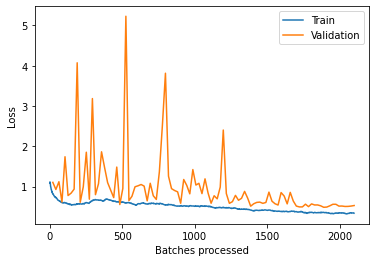

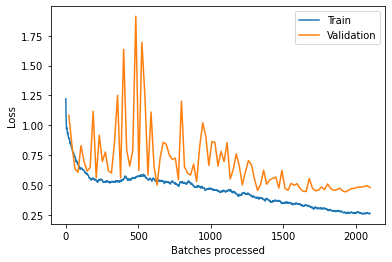

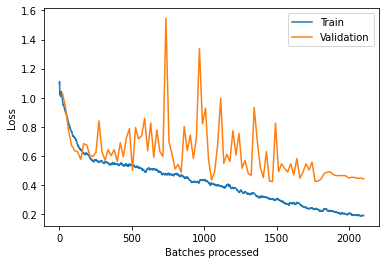

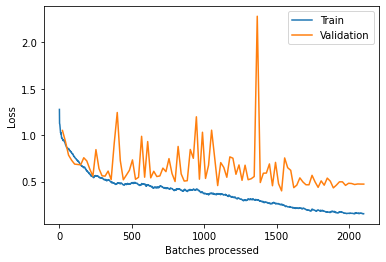

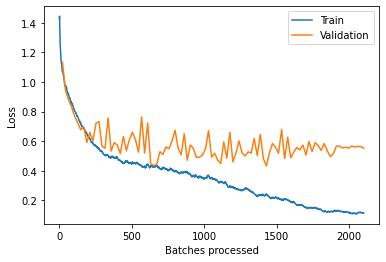

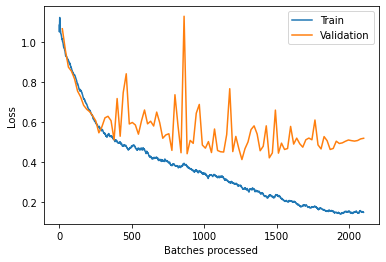

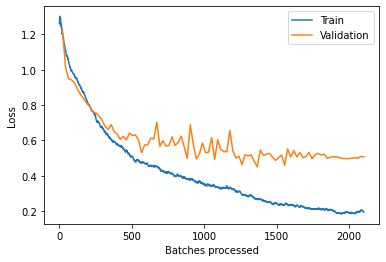

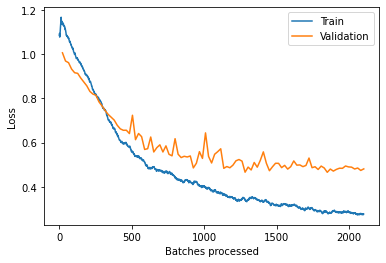

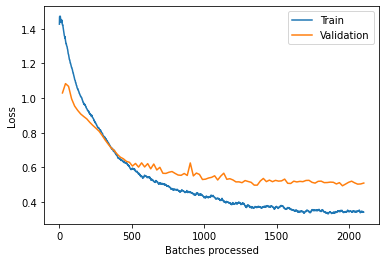

In [ ]:
lr_init=lr=1e-2
count=1
#with learn.no_bar(), learn.no_logging():
while lr > 1e-5:
  print(lr)

  model = nn.Sequential(
    conv_block(3, 8),
    maxpooling(),
    conv_block(8, 16),
    maxpooling(),
    triple_conv(16, 32),
    maxpooling(),
    triple_conv(32, 64),
    maxpooling(),
    triple_conv(64, 128),
    maxpooling(),
    triple_conv(128, 256),
    conv_block(256, 128, size=1),
    conv_block(128, 256),
    conv_layer(256, 3),
    Flatten(),
    nn.Linear(507, 3)
  )

  learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=[accuracy, error_rate])
  #learn.lr_find()
  learn.fit_one_cycle(100, max_lr = lr) #1e-4 #100
  learn.recorder.plot_losses()
  count=count+1
  lr = lr_init*0.5**count

In [ ]:
#with learn.no_bar(), learn.no_logging(): 
  #learn.fit_one_cycle(20, max_lr = 5e-4) #1e-4 #100

### save model

In [ ]:
# save model
# learn.save('/content/output/models/learn_1e-4')

### load model

In [ ]:
# learn.load('/content/output/models/learn_1e-4')

### read in test set

ref: https://forums.fast.ai/t/calculating-the-accuracy-for-test-set/39360/14

In [ ]:
# Create Databunch
il = ImageList.from_folder(path='/content/output/test')
ils = il.split_none() #All data on Train Set
ll = ils.label_from_folder()
ll.valid = ll.train 
ll.transform(tfms=None,size=256) # Optional Transforms
data = ll.databunch(bs=32);
# data.normalize(stats)
data.normalize()

ImageDataBunch;

Train: LabelList (225 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
No_findings,No_findings,No_findings,No_findings,No_findings
Path: /content/output/test;

Valid: LabelList (225 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
No_findings,No_findings,No_findings,No_findings,No_findings
Path: /content/output/test;

Test: None

In [ ]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Covid-19', 'No_findings', 'Pneumonia'], 3, 225, 225)

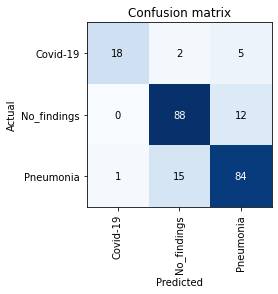

In [ ]:
learn.data.valid_dl = data.valid_dl

# Interpret
interp = ClassificationInterpretation.from_learner(learn,ds_type=DatasetType.Valid)
interp.plot_confusion_matrix()

### predict class

In [ ]:
probs,targets = learn.get_preds(ds_type=DatasetType.Valid)

# probs,targets = learn.get_preds(ds_type=data.valid_dl)
predict_labels = np.argmax(probs, 1)
len(predict_labels)

225

In [ ]:
probs = np.argmax(probs, axis=1)
correct = 0
for idx, pred in enumerate(probs):
    if pred == targets[idx]:
        correct += 1
accuracy = correct / len(probs)
print(len(probs), correct, accuracy)

from sklearn.metrics import confusion_matrix
np.set_printoptions(threshold=np.inf) # shows whole confusion matrix
cm1 = confusion_matrix(targets, probs)
print(cm1)

from sklearn.metrics import classification_report, multilabel_confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
y_true = targets
y_pred = probs
target_names = ['Covid-19', 'No_findings', 'Pneumonia']
print(classification_report(y_true, y_pred, target_names=target_names))

225 190 0.8444444444444444
[[18  2  5]
 [ 0 88 12]
 [ 1 15 84]]
              precision    recall  f1-score   support

    Covid-19       0.95      0.72      0.82        25
 No_findings       0.84      0.88      0.86       100
   Pneumonia       0.83      0.84      0.84       100

    accuracy                           0.84       225
   macro avg       0.87      0.81      0.84       225
weighted avg       0.85      0.84      0.84       225



In [ ]:
interp.confusion_matrix()

array([[18,  2,  5],
       [ 0, 88, 12],
       [ 1, 15, 84]])

In [ ]:
print(multilabel_confusion_matrix(y_true, y_pred))

[[[199   1]
  [  7  18]]

 [[108  17]
  [ 12  88]]

 [[108  17]
  [ 16  84]]]


In [ ]:
multi_class_matrix = multilabel_confusion_matrix(y_true, y_pred)

Note that in binary classification, recall of the positive class is also known as “sensitivity”; recall of the negative class is “specificity”.

matrix for:  Covid-19
	 Accuracy :  0.964
	 Sensitivity :  0.72
	 Specificity :  0.995
	 F1-score :  0.818
matrix for:  No_findings
	 Accuracy :  0.871
	 Sensitivity :  0.88
	 Specificity :  0.864
	 F1-score :  0.859
matrix for:  Pneumonia
	 Accuracy :  0.853
	 Sensitivity :  0.84
	 Specificity :  0.864
	 F1-score :  0.836


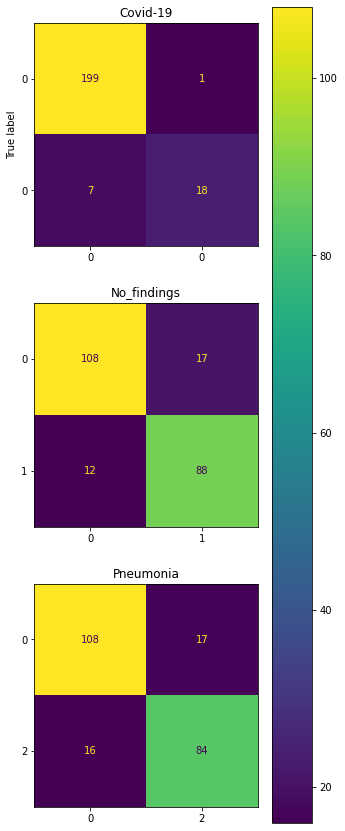

In [ ]:
f, axes = plt.subplots(3, 1, figsize=(5, 15))
axes = axes.ravel()
for i in range(3):
    disp = ConfusionMatrixDisplay(confusion_matrix(y_true==i,
                                                   y_pred==i),
                                  display_labels=[0, i])
    disp.plot(ax=axes[i], values_format='.4g')
    disp.ax_.set_title(target_names[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

    print('matrix for: ', target_names[i])
    cm1 = confusion_matrix(y_true==i, y_pred==i)
    #####from confusion matrix calculate accuracy
    total1=sum(sum(cm1))
    accuracy1=(cm1[0,0]+cm1[1,1])/total1
    print ('\t Accuracy : ', round(accuracy1,3))

    sensitivity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    print('\t Sensitivity : ', sensitivity1 )

    specificity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    print('\t Specificity : ', specificity1)

    F1_score = cm1[1,1]/(cm1[1,1] + 0.5*(cm1[1,0]+cm1[0,1]))
    print('\t F1-score : ', round(F1_score,3))

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

In [ ]:
# accuracy(probs,targets)

This plots the top ‘n’ classes where the classifier has least precision

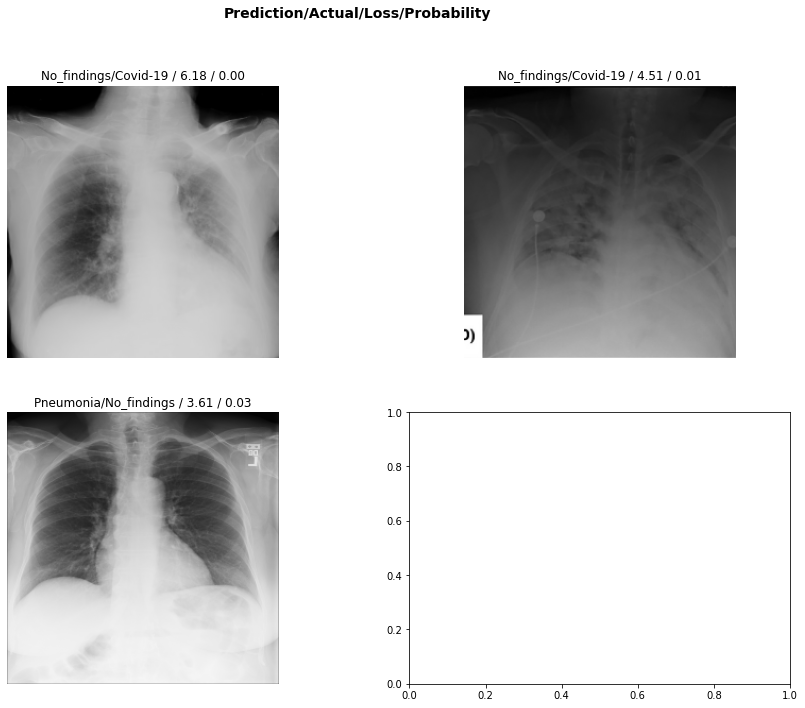

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(3, figsize=(15,11), heatmap=False)

## get labels and classes

In [ ]:
# labels = np.argmax(probs, 1)
# labels

In [ ]:
# test_predictions_direct = [data.classes[int(x)] for x in labels]
# test_predictions_direct

## precision and sensitivity 